In [1]:
import zstandard as zstd
import json
import os
import io
from tqdm import tqdm
from nnsight import LanguageModel
from dictionary_learning.buffer import ActivationBuffer
from dictionary_learning.dictionary import AutoEncoder
from dictionary_learning.training import trainSAE
import torch as t

/share/u/smarks/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')
submodule = model.gpt_neox.layers[2].mlp.dense_4h_to_h

In [3]:
# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')
def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

In [4]:
buffer = ActivationBuffer(
    data,
    model,
    submodule,
    in_batch_size=64,
    out_batch_size=4096,
    n_ctxs=5e4,
    device='cuda:0'
)

In [5]:
ae = trainSAE(
    buffer,
    activation_dim=512,
    dictionary_size = 8 * 512,
    steps=1000,
    lr = 1e-3,
    sparsity_penalty = 3e-4,
    entropy=False,
    resample_steps = 1000,
    log_steps = None,
    device='cuda:0'
)

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


refreshing buffer...


/share/u/smarks/.local/lib/python3.8/site-packages/transformers/generation/utils.py:2507: UserWarning: Specified kernel cache directory is not writable! This disables kernel caching. Specified directory is /share/u/smarks/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at ../aten/src/ATen/native/cuda/jit_utils.cpp:1460.)
  next_tokens.tile(eos_token_id_tensor.shape[0], 1).ne(eos_token_id_tensor.unsqueeze(1)).prod(dim=0)


buffer refreshed...
step 0 autoencoder loss: 0.7744720578193665
step 0 % inactive: 0.0
step 0 reconstruction loss: 3.4654366970062256, 4.7864532470703125, 4.347995281219482
step 30 autoencoder loss: 0.09351757168769836
step 30 % inactive: 0.0
step 30 reconstruction loss: 3.540593147277832, 3.9492151737213135, 4.3314032554626465
step 60 autoencoder loss: 0.0742626041173935
step 60 % inactive: 0.0
step 60 reconstruction loss: 3.4906044006347656, 3.6950414180755615, 4.261730194091797
refreshing buffer...
buffer refreshed...
step 90 autoencoder loss: 0.06487508118152618
step 90 % inactive: 0.0
step 90 reconstruction loss: 3.4171013832092285, 3.610360622406006, 4.20655632019043
step 120 autoencoder loss: 0.0584874227643013
step 120 % inactive: 0.001708984375
step 120 reconstruction loss: 3.3146800994873047, 3.4892454147338867, 4.09421968460083
step 150 autoencoder loss: 0.054265595972537994
step 150 % inactive: 0.01318359375
step 150 reconstruction loss: 3.357200860977173, 3.504809141159057

In [6]:
ae = AutoEncoder(512, 4*512).cuda()
ae.load_state_dict(t.load('autoencoders/reg0.0001_entFalse.pt'))

<All keys matched successfully>

In [6]:
acts = next(buffer)

Matplotlib created a temporary cache directory at /tmp/matplotlib-iqmhgtg5 because the default path (/share/u/smarks/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


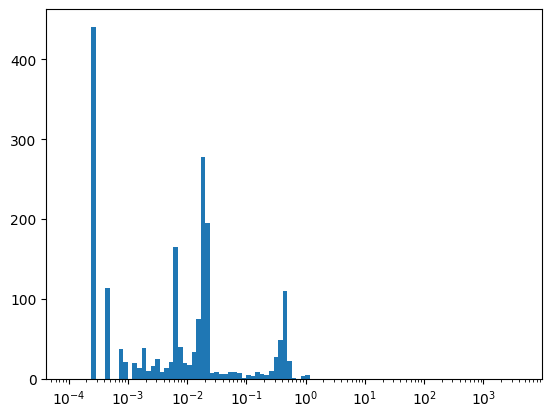

In [7]:
import numpy as np
dict_acts = ae.encode(acts.cuda())
freqs = (dict_acts !=0).sum(dim=0) / dict_acts.shape[0]

import matplotlib.pyplot as plt
plt.hist(freqs.cpu(), bins=np.logspace(np.log10(1e-4), np.log10(4096), 100))
plt.xscale('log')

plt.show()

In [30]:
t.nonzero(1 - (dict_acts == 0).all(dim=0).float())

tensor([[   1],
        [   2],
        [   4],
        ...,
        [4083],
        [4089],
        [4093]], device='cuda:0')

In [8]:
ae.encode(acts.cuda())

tensor([[2.1049e-01, 7.3272e-02, 2.1830e-01,  ..., 2.0369e-01, 4.2124e-02,
         2.5463e-01],
        [2.1436e-01, 3.4365e-02, 1.2208e-01,  ..., 3.8042e-02, 0.0000e+00,
         3.0747e-02],
        [2.8846e-01, 2.4418e-01, 2.6713e-01,  ..., 3.2065e-01, 5.4556e-03,
         3.1329e-01],
        ...,
        [4.7642e-01, 2.5845e-01, 2.6834e-01,  ..., 0.0000e+00, 1.3256e-01,
         3.3008e-01],
        [7.5465e-01, 0.0000e+00, 0.0000e+00,  ..., 6.1018e+00, 0.0000e+00,
         0.0000e+00],
        [1.4123e-01, 3.7879e-01, 1.3614e-01,  ..., 1.5555e-01, 2.5206e-01,
         2.3779e-01]], device='cuda:0', grad_fn=<ReluBackward0>)

In [8]:
from einops import rearrange
import torch as t

inputs = buffer.tokenized_batch()
with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
    with generator.invoke(inputs['input_ids'], scan=False) as invoker:
        hidden_states = submodule.output.save()
dictionary_activations = ae.encode(hidden_states.value)
flattened_acts = rearrange(dictionary_activations, 'b n d -> (b n) d')
freqs = (flattened_acts !=0).sum(dim=0) / flattened_acts.shape[0]

In [40]:
for idx, freq in enumerate(freqs):
    if 3e-3 < freq and freq < 1e-2:
        print(f"feat {idx} freq: {freq}")

feat 5 freq: 0.007568359375
feat 47 freq: 0.00732421875
feat 48 freq: 0.0054931640625
feat 74 freq: 0.0074462890625
feat 118 freq: 0.0076904296875
feat 126 freq: 0.0072021484375
feat 128 freq: 0.0074462890625
feat 146 freq: 0.0057373046875
feat 173 freq: 0.0072021484375
feat 179 freq: 0.009765625
feat 189 freq: 0.00732421875
feat 233 freq: 0.0072021484375
feat 263 freq: 0.0072021484375
feat 269 freq: 0.0098876953125
feat 280 freq: 0.008056640625
feat 343 freq: 0.0072021484375
feat 346 freq: 0.0072021484375
feat 375 freq: 0.007568359375
feat 381 freq: 0.0078125
feat 383 freq: 0.007568359375
feat 386 freq: 0.0089111328125
feat 390 freq: 0.0081787109375
feat 400 freq: 0.005126953125
feat 403 freq: 0.0087890625
feat 410 freq: 0.007568359375
feat 422 freq: 0.00732421875
feat 446 freq: 0.007568359375
feat 447 freq: 0.0074462890625
feat 452 freq: 0.007568359375
feat 456 freq: 0.00732421875
feat 473 freq: 0.0072021484375
feat 474 freq: 0.00732421875
feat 489 freq: 0.0084228515625
feat 499 freq

In [33]:
def list_decode(x):
    if isinstance(x, int):
        return model.tokenizer.decode(x)
    else:
        return [list_decode(y) for y in x]

In [45]:
k = 30
feat = 400
acts = dictionary_activations[:, :, feat].cpu()
flattened_acts = rearrange(acts, 'b l -> (b l)')
topk_indices = t.argsort(flattened_acts, dim=0, descending=True)[:k]
batch_indices = topk_indices // acts.shape[1]
token_indices = topk_indices % acts.shape[1]

In [46]:
from circuitsvis.activations import text_neuron_activations

tokens = [
    inputs['input_ids'][batch_idx, :token_idx+1].tolist() for batch_idx, token_idx in zip(batch_indices, token_indices)
]
tokens = list_decode(tokens)
activations = [
    acts[batch_idx, :token_id+1, None, None] for batch_idx, token_id in zip(batch_indices, token_indices)
]
text_neuron_activations(tokens, activations)

In [18]:
batch_indices

tensor([40, 40, 40, 40, 40, 40, 40, 40, 15,  7,  7,  1, 15, 15, 15, 40, 15, 15,
        15,  7, 53, 53, 15, 15,  7, 15, 15, 46,  1, 15])

In [19]:
print(model.tokenizer.decode(inputs[40].ids))


972 P.2d 566 (1999)
CITY OF TACOMA, a municipal corporation, Appellant,
v.
FRANCISCAN FOUNDATION, aka St. Joseph Hospital And Healthcare Center, a Washington nonprofit corporation, Respondent.
No. 23107-7-II.
Court of Appeals of Washington, Division 2.
March 5, 1999.
*567 Jean P Homan, Assistant City Attorney, Tacoma, for Appellant.
Linda Gayle White Atkins, Davis Wright Tremaine, Bellevue, for Respondent.
HOUGHTON, J.



In [22]:
import numpy as np
import torch
k = 10
found_indices = torch.argsort(dictionary_activations, descending=True)[:k]
num_datapoints = int(dictionary_activations.shape[0]/128)
datapoint_indices =[np.unravel_index(i, (64, 128)) for i in found_indices]
text_list = []
full_text = []
token_list = []
full_token_list = []
for md, s_ind in datapoint_indices:
    md = int(md)
    s_ind = int(s_ind)
    full_tok = torch.tensor(dataset[md]["input_ids"])
    full_text.append(tokenizer.decode(full_tok))
    tok = dataset[md]["input_ids"][:s_ind+1]
    text = tokenizer.decode(tok)
    text_list.append(text)
    token_list.append(tok)
    full_token_list.append(full_tok)
text_list, full_text, token_list, full_token_list

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
import torch 
# num_features, d_model = autoencoder.encoder.shape # Fix this for shape purposes
texts = buffer.text_batch()
datapoints = len(texts)
batch_size = 64
neuron_activations = torch.zeros((datapoints*max_length, d_model))
dictionary_activations = torch.zeros((datapoints*max_length))

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        # Replace this with your residual stream stuff
        # _, cache = model.run_with_cache(batch.to(device))
        # batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )

        # Replace with your projection to probe direction
        # batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)
        dictionary_activations[i*batch_size*max_length:(i+1)*batch_size*max_length] = batched_dictionary_activations.cpu()

In [9]:
import torch as t
def entropy(p):
    p = p/p.sum(dim=-1, keepdim=True)
    log_p = p.log().nan_to_num()
    entropies = -(p * log_p).sum(dim=-1)
    out = entropies.nan_to_num().mean()
    return out

In [10]:
x = t.Tensor([[0, 0,0], [1, 4, 2]])
entropy(x)

tensor(0.4778)

In [11]:
x

tensor([[0., 0., 0.],
        [1., 4., 2.]])

In [12]:
x * x.log()

tensor([[   nan,    nan,    nan],
        [0.0000, 5.5452, 1.3863]])

In [6]:
0 * float("-inf")

nan

In [1]:
import torch as t

def entropy(p):
    eps = 1e-8
    # Calculate the sum along the last dimension (i.e., sum of each vector in the batch)
    p_sum = p.sum(dim=-1, keepdim=True)
    
    # Avoid in-place operations that can interfere with autograd
    p_normed = p / (p_sum + eps)  # Add eps to prevent division by zero
    
    # Compute the log safely, adding eps inside the log to prevent log(0)
    p_log = t.log(p_normed + eps)  # Add eps to prevent log(0)

    # Compute the entropy, this will give zero for elements where p_normed is zero
    ent = -(p_normed * p_log)
    
    # Zero out the entropy where the sum of p is zero (i.e., for all-zero vectors)
    ent = t.where(p_sum > 0, ent, t.zeros_like(ent))

    # Sum the entropy across the features and then take the mean across the batch
    return ent.sum(dim=-1).mean()

# Example usage:
batch_size = 3
vector_length = 5
p = t.tensor([[0.1, 0.2, 0.7, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0],  # All-zero vector
              [0.3, 0.3, 0.4, 0.0, 0.0]], requires_grad=True)

entropy_value = entropy(p)
entropy_value.backward()

print("Entropy:", entropy_value.item())
print("Gradients:", p.grad)

Entropy: 0.6302395462989807
Gradients: tensor([[ 0.5003,  0.2692, -0.1484,  6.2063,  6.2063],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0384,  0.0384, -0.0575,  6.1106,  6.1106]])
